
# Time series analysis and prediction for electricity consumption and renewable generation for European countries

## Data Description

### Source - Open Power System Data 
- The main table contains load(electricity consumption), wind generation, and solar generation for European countries sampled at every 1 hour from 2006 till 2017.
- Data aggregation is done daily wise using sql query and a new table is created which holds this aggregated data  
- This daily aggregation is done only for Germany which would be the focus of analysis proceeding further


### Goal
- Analysis of seasonality and trends.
- Forecasting electicity consumption, solar generation, and wind generation.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import folium
import json
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()
#from mpl_toolkits.basemap import Basemap

In [51]:
main_db_name = "TimeSeries.db"

In [52]:
import os
import sqlite3
from sqlite3 import Error
import gzip

def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_query(conn, query):
    crsr = conn.cursor()
    results = crsr.execute(query)
    results = results.fetchall()
    return results

In [53]:
db_conn = create_connection(main_db_name)

## Load analysis for all European countries

- Initially we want to understand how consumption and generation is varying across all European countries.
- So we are generating a geographic plot that describes the intensity

Steps:
- Aggregate data in the main table for every country
- Border extraction for all the countries
- Plotting on the graph using Folium

In [54]:
country_initials_all = ["DE", "GB", "GB_UKM", "GR", "HR", "HU", "IE", "IS", "IT", "LT", "LU", "LV", "ME", "MK", "NL", "NO", "PL", "PT",
                    "RO", "RS", "SE", "SI", "SK", "TR", "UA", "FR", "ES", "BE", "CH", "AT", "CZ", "BA", "DK"]

country_initials = ["GB_UKM", "DE", "GR", "HR", "HU", "IE", "IS", "IT", "LT", "LU", "LV", "ME", "MK", "NL", "NO", "PL", "PT",
                    "RO", "RS", "SE", "SI", "SK", "TR", "FR", "ES", "BE", "CH", "AT", "CZ", "BA", "DK"]

country_codes = pd.read_csv("CountryCodes.csv") 

In [55]:
country_codes = country_codes.set_index("Country Code")

In [56]:
country_names_set = set(country_codes['Country Name'])

In [57]:
# ONE TIME UTILITIES
with open('world-countries.json') as json_file:
    country_coords_geo = json.load(json_file)
features_array = []
country_coords = country_coords_geo['features']
for country_coord_info in country_coords:
    country_name = country_coord_info['properties']['name']
    if country_name in country_names_set:
        #print(country_name+" found")
        features_array.append(country_coord_info);
    else:
        #print(country_name+" not found")
        pass;
        
features_array
europe_countries_geo = {'type': 'FeatureCollection', 'features': features_array}
with open("europe_countries_geo.json", 'w') as outfile:
    json.dump(europe_countries_geo, outfile)

In [58]:
column_names = []
query_str = "select substr(utc_timestamp, 1, 10) as Time"
for country_init in country_initials:
    country_name = country_codes.loc[country_init]["Country Name"]
    country_name = country_name.replace(" ", "_") 
    query_str = query_str + ", sum({}_load_actual_entsoe_power_statistics) as {}_Load".format(country_init, country_name)
    column_names.append("{}_Load".format(country_init))
query_str = query_str + """ from Time_series_60min where date(utc_timestamp) < date('2018-01-01') and date(utc_timestamp) > date('2005-12-31') GROUP BY substr(utc_timestamp, 1, 10)"""

In [59]:
db_conn = create_connection(main_db_name)
#result = execute_query(db_conn, query_str)
all_aggregated = pd.read_sql_query(query_str, db_conn)

### Sample data after aggregation

In [60]:
all_aggregated.sample(8)

,Time,United_Kingdom_Load,Germany_Load,Greece_Load,Croatia_Load,Hungary_Load,Ireland_Load,Iceland_Load,Italy_Load,Lithuania_Load,...,Slovakia_Load,Turkey_Load,France_Load,Spain_Load,Belgium_Load,Switzerland_Load,Austria_Load,Czech_Republic_Load,Bosnia_Herzegovina_Load,Denmark_Load
3043,2014-05-02,9.196640e+05,1.348640e+06,101049.0,41549.0,90153.00,68818.00,45892.00,739948.0,26656.0000,...,68914.00,NaN,1161521.0,584964.0,210406.0,118254.0,171029.0,152456.0,29263.0,84766.00
3744,2016-04-02,9.577147e+05,1.243312e+06,124277.0,42354.0,104314.79,72228.00,49688.02,757703.0,27563.0000,...,71979.77,699491.89,1313533.0,630010.0,217117.0,152806.0,164434.0,159484.0,31308.0,80227.80
1669,2010-07-28,8.429028e+05,1.457718e+06,160272.0,47040.0,102664.00,65665.00,43551.00,987778.0,27075.7893,...,68262.00,NaN,1204834.0,792419.0,213952.0,104805.0,148125.0,151805.0,30835.0,82477.00
2853,2013-10-24,9.391632e+05,1.510104e+06,113202.0,44986.0,108390.00,74278.00,49155.00,910375.0,30684.0000,...,79909.00,NaN,1221678.0,673501.0,249929.0,130068.0,202231.0,177306.0,33366.0,96646.00
4361,2017-12-10,1.112660e+06,1.345010e+06,136506.0,50388.0,116667.96,80299.97,52495.09,759446.0,31974.0000,...,83231.61,739637.93,1577571.0,649216.0,244604.0,184779.0,194621.0,187832.0,36267.0,96992.54
2860,2013-10-31,9.426953e+05,1.486102e+06,113915.0,44178.0,109715.00,74311.00,49815.00,888753.0,29300.0000,...,78032.00,NaN,1346439.0,656472.0,252248.0,131556.0,198993.0,187946.0,34061.0,99375.00
3753,2016-04-11,1.059797e+06,1.440970e+06,123271.0,44005.0,112392.97,79623.00,50194.77,833838.0,30792.0000,...,77085.01,719799.00,1305769.0,702461.0,231425.0,168943.0,190611.0,185780.0,31304.0,92962.20
2987,2014-03-07,1.001004e+06,1.561749e+06,136930.0,48488.0,115481.00,77004.00,47169.00,929625.0,31002.0000,...,79462.00,NaN,1507939.0,707831.0,249195.0,155663.0,208765.0,189441.0,35790.0,99913.00


In [61]:
# get the load aggregate of country and its geocode
all_aggregated_desc = all_aggregated.describe()

In [62]:
mean_sum = 0
#all_country_geocode_agg_info = []
all_country_mean = {}
for country_initial in country_initials:
    country_name = country_codes.loc[country_initial]["Country Name"]
    country_name_orignal = country_name
    country_name = country_name.replace(" ", "_")
    country_key = country_name+"_Load"
    country_mean = all_aggregated_desc[country_key]["mean"]
    mean_sum = mean_sum + country_mean
    all_country_mean[country_name_orignal] = country_mean

In [63]:
m = folium.Map(location=[66.546245,12.601554], zoom_start=2.7)
#tiles = "mapbox://styles/jeetendragan/ck3rzede719tg1cpalsivhz7p",
#attr = "<a href=https://mapbox.com/>Mapbox</a>"

folium.Choropleth(
    geo_data ="europe_countries_geo.json",
    name ='OpenStreetMap',
    data = all_country_mean,
    columns=["Country","Mean"],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.9,
    legend_name='Load'
).add_to(m)

folium.LayerControl().add_to(m)

m

### Observations
- Germany, followed by France, and then my United Kingdom have the highest consumption
- Montenegro, Luxembourg, Latvia have the lowest consumption
- Related to the population

## Solar Generation

In [64]:
#country_initials_with_solar = ["GR", "IT", "LT", "NL", "PT", "RO", "SE", "SI", "SK", "DE"]
country_initials_with_solar = ["DE", "GB_UKM", "GR", "IT", "LT", "NL", "PT",
                    "RO", "SE", "SI", "SK", "FR", "ES", "BE", "CH", "AT", "CZ"]

column_names = []
query_str = "select substr(utc_timestamp, 1, 10) as Time"
for country_init in country_initials_with_solar:
    country_name = country_codes.loc[country_init]["Country Name"]
    country_name = country_name.replace(" ", "_")
    query_str = query_str + ", sum({}_solar_generation_actual) as {}_Solar".format(country_init, country_name)
    column_names.append("{}_Solar".format(country_init))
    
query_str = query_str + """ from Time_series_60min where date(utc_timestamp) < date('2018-01-01') and date(utc_timestamp) > date('2005-12-31') GROUP BY substr(utc_timestamp, 1, 10)"""

In [65]:
db_conn = create_connection(main_db_name)
#result = execute_query(db_conn, query_str)
solar_all_aggregated = pd.read_sql_query(query_str, db_conn)

In [66]:
solar_all_aggregated_desc = solar_all_aggregated.describe()

In [67]:
mean_solar = 0
all_country_solar_mean = {}
for country_initial in country_initials:
    country_name = country_codes.loc[country_initial]["Country Name"]
    country_name_orignal = country_name
    country_name = country_name.replace(" ", "_")
    country_key = country_name+"_Solar"
    if country_key in solar_all_aggregated:
        country_mean = solar_all_aggregated_desc[country_key]["mean"]
        mean_solar = mean_solar + country_mean
        all_country_solar_mean[country_name_orignal] = country_mean

In [94]:
m_solar = folium.Map(location=[66.546245,12.601554], zoom_start=2.7)
#tiles = "mapbox://styles/jeetendragan/ck3rzede719tg1cpalsivhz7p",
#attr = "<a href=https://mapbox.com/>Mapbox</a>"

folium.Choropleth(
    geo_data ="europe_countries_geo.json",
    name ='OpenStreetMap',
    data = all_country_solar_mean,
    columns=["Country","Mean"],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.9,
    legend_name='Solar Generation'
).add_to(m_solar)

folium.LayerControl().add_to(m_solar)

m_solar

### Observations
- Germany tops the list again, followed by Italy, Spain, and then United Kingdom
- Sweden, Lithuania, and Slovenia, generate the least solar electricity

### Wind Generation

In [70]:
#country_initials_wind = ["SE", "DE"]
country_initials_wind = ["DE", "SE"]

column_names = []
query_str = "select substr(utc_timestamp, 1, 10) as Time"
for country_init in country_initials_wind:
    country_name = country_codes.loc[country_init]["Country Name"]
    country_name = country_name.replace(" ", "_")
    query_str = query_str + ", sum({}_wind_generation_actual) as {}_Wind".format(country_init, country_name)
    column_names.append("{}_Wind".format(country_init))
query_str = query_str + ", sum(GB_UKM_wind_offshore_generation_actual) as United_Kingdom_Wind"
query_str = query_str + ", sum(GR_wind_onshore_generation_actual) as Greece_Wind"
query_str = query_str + ", sum(HU_wind_onshore_generation_actual) as Hungary_Wind"
query_str = query_str + ", sum(IE_wind_onshore_generation_actual) as Ireland_Wind"
query_str = query_str + ", sum(IT_wind_onshore_generation_actual) as Italy_Wind"
query_str = query_str + ", sum(LT_wind_onshore_generation_actual) as Lithuania_Wind"
query_str = query_str + ", sum(LV_wind_onshore_generation_actual) as Latvia_Wind"
query_str = query_str + ", sum(ME_wind_onshore_generation_actual) as Montenegro_Wind"
query_str = query_str + ", sum(MK_wind_onshore_generation_actual) as Yugoslav_Republic_of_Macedonia_Wind"
query_str = query_str + ", sum(NL_wind_onshore_generation_actual) as Neatherlands_Wind"
query_str = query_str + ", sum(NO_wind_onshore_generation_actual) as Norway_Wind"
query_str = query_str + ", sum(FR_wind_onshore_generation_actual) as France_Wind"
query_str = query_str + ", sum(ES_wind_onshore_generation_actual) as Spain_Wind"
query_str = query_str + ", sum(BE_wind_onshore_generation_actual) as Belgium_Wind"
query_str = query_str + ", sum(CH_wind_onshore_generation_actual) as Switzerland_Wind"
query_str = query_str + ", sum(AT_wind_onshore_generation_actual) as Austria_Wind"
query_str = query_str + ", sum(CZ_wind_onshore_generation_actual) as Czech_Republic_Wind"
#query_str = query_str + ", sum(BA_wind_onshore_generation_actual) as Bosnia_Wind"
query_str = query_str + ", sum(DK_wind_onshore_generation_actual) as Denmark_Wind"


query_str = query_str + """ from Time_series_60min where date(utc_timestamp) < date('2018-01-01') and date(utc_timestamp) > date('2005-12-31') GROUP BY substr(utc_timestamp, 1, 10)"""

In [71]:
db_conn = create_connection(main_db_name)
#result = execute_query(db_conn, query_str)
wind_all_aggregated = pd.read_sql_query(query_str, db_conn)

In [72]:
wind_all_aggregated_desc = wind_all_aggregated.describe()

In [73]:
all_countries_with_wind = ["DE", "SE", "GB_UKM", "GR", "HU", "IE", "IT", "LV", "ME", "MK",
                          "NL", "NO", "FR", "ES", "BE", "CH", "AT", "CZ", "DK"]
mean_wind = 0
all_country_wind_mean = {}
for country_initial in all_countries_with_wind:
    country_name = country_codes.loc[country_initial]["Country Name"]
    country_name_orignal = country_name
    country_name = country_name.replace(" ", "_")
    country_key = country_name+"_Wind"
    if country_key in wind_all_aggregated_desc:
        country_mean = wind_all_aggregated_desc[country_key]["mean"]
        mean_wind = mean_wind + country_mean
        all_country_wind_mean[country_name_orignal] = country_mean
        

In [76]:
m_wind = folium.Map(location=[66.546245,12.601554], zoom_start=2.7)
#tiles = "mapbox://styles/jeetendragan/ck3rzede719tg1cpalsivhz7p",
#attr = "<a href=https://mapbox.com/>Mapbox</a>"

folium.Choropleth(
    geo_data ="europe_countries_geo.json",
    name ='OpenStreetMap',
    data = all_country_wind_mean,
    columns=["Country","Mean"],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.9,
    legend_name='Load'
).add_to(m_wind)

folium.LayerControl().add_to(m_wind)

m_wind

### Observations
- Largest solar producers - Germany, Spain, France, Italy
- Lowest solar producers - Switzerland, Macedonia, Latvia

## Analysis of Germany data

As Germany not only consumes and builds great cars but also electricity, it is the focus of analysis!

In [77]:
query = """SELECT substr(utc_timestamp, 1, 10) as Time, 
    sum(DE_load_actual_entsoe_power_statistics) as Load, 
    sum(DE_solar_generation_actual) as Solar_Gen,
    sum(DE_wind_generation_actual) as Wind_Gen,
    (sum(DE_solar_generation_actual) + sum(DE_wind_generation_actual)) as SolarAndWind
    from Time_series_60min
    where date(utc_timestamp) < date('2018-01-01') and date(utc_timestamp) > date('2005-12-31')
    GROUP BY substr(utc_timestamp, 1, 10)
"""
result = execute_query(db_conn, query)
data_f = pd.DataFrame(result, columns=["Time", "Load", "Solar_Gen", "Wind_Gen", "SolarAndWind"])
data_f['Time'] = pd.to_datetime(data_f['Time'])
data_f = data_f.set_index('Time')
data_f['Year'] = data_f.index.year
data_f['Month'] = data_f.index.month
data_f['Weekday Name'] = data_f.index.weekday_name
data_f.tail(8)

,Load,Solar_Gen,Wind_Gen,SolarAndWind,Year,Month,Weekday Name
Time,,,,,,,
2017-12-24,1.165058e+06,9949.0,812422.0,822371.0,2017,12,Sunday
2017-12-25,1.133963e+06,15765.0,587810.0,603575.0,2017,12,Monday
2017-12-26,1.153180e+06,30923.0,717453.0,748376.0,2017,12,Tuesday
2017-12-27,1.289736e+06,16530.0,394507.0,411037.0,2017,12,Wednesday
2017-12-28,1.326392e+06,14162.0,506424.0,520586.0,2017,12,Thursday
2017-12-29,1.321518e+06,29854.0,584277.0,614131.0,2017,12,Friday
2017-12-30,1.240254e+06,7467.0,721247.0,728714.0,2017,12,Saturday
2017-12-31,1.131226e+06,19980.0,721176.0,741156.0,2017,12,Sunday


In [78]:
sns.set(rc={'figure.figsize':(11, 4)});

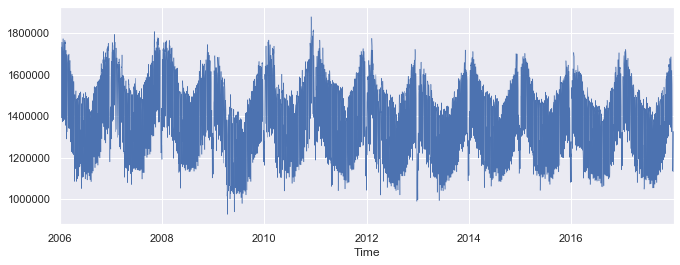

In [79]:
data_f['Load'].plot(linewidth = 0.5);

Electricity consumption with respect to time from 2006 - 2017 for Germany

### Patterns seen 
- Usage across all years follows a similar pattern.

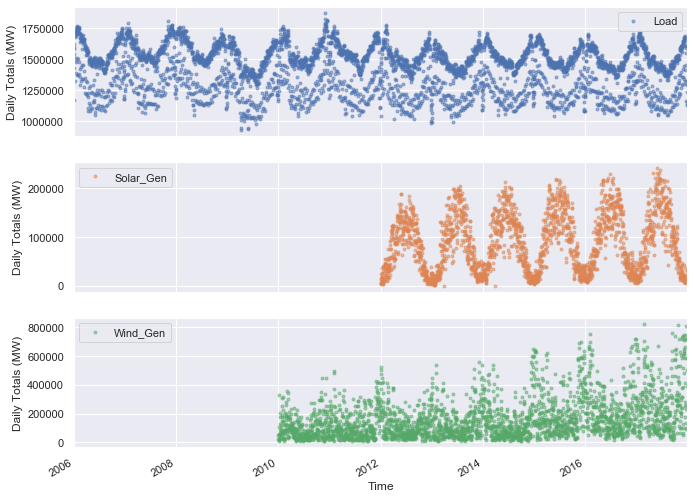

In [80]:
cols_plot = ['Load', 'Solar_Gen', 'Wind_Gen']
axes = data_f[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (MW)')

### Observations
- Seasonality can be seen in the solar generation.
- Not much in wind generation.

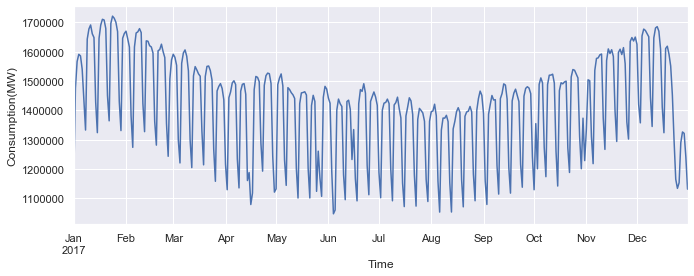

In [81]:
ax = data_f.loc['2017', 'Load'].plot()
ax.set_ylabel('Consumption(MW)');

### Monthly trend
- As all years follow a similar pattern we have selected 2017 to study the monthly pattern. 
- The electricity consumption is larger in winter months and less in summers.

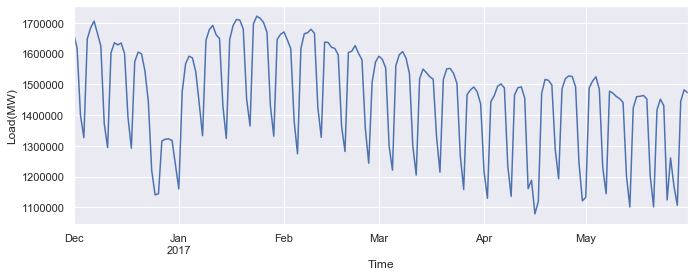

In [82]:
ax = data_f.loc['2016-12':'2017-05', 'Load'].plot()
ax.set_ylabel('Load(MW)');
# TODO - Add multi-year trend to describe the dip in usage

- Consumption dip noticed at around New Year's. Drop around late December and early January.

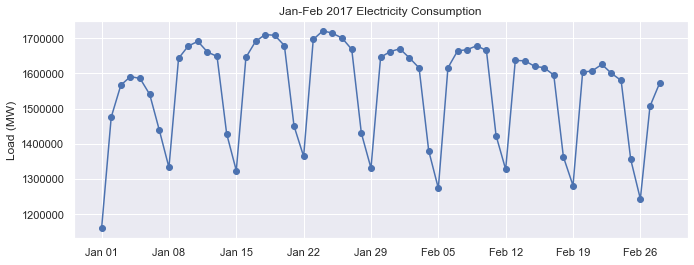

In [83]:
fig, ax = plt.subplots()
ax.plot(data_f.loc['2017-01':'2017-02', 'Load'], marker='o', linestyle='-')
ax.set_ylabel('Load (MW)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

- Greater usage on weekdays. 

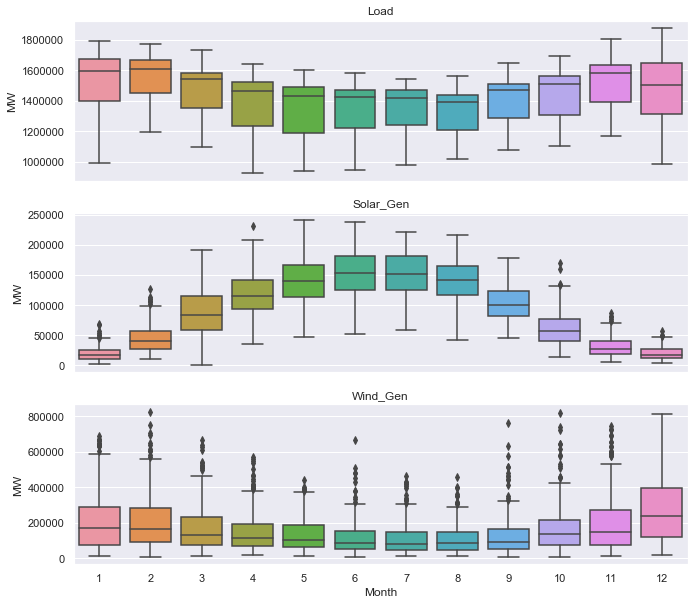

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Load', 'Solar_Gen', 'Wind_Gen'], axes):
    sns.boxplot(data=data_f, x='Month', y=name, ax=ax)
    ax.set_ylabel('MW')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

- Yearly seasonality can be seen for load, solar generation, and wind generation.

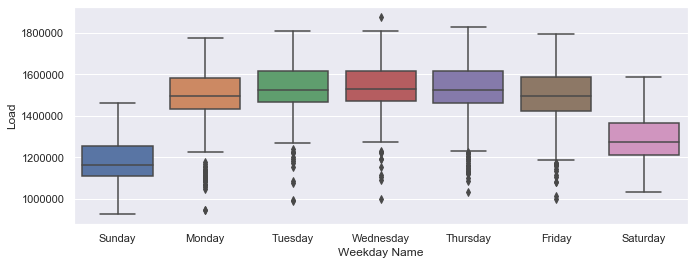

In [85]:
sns.boxplot(data = data_f, x='Weekday Name', y='Load');

- Shows weekly seasonality

# Trends

In [86]:
data_columns = ['Load', 'Wind_Gen', 'Solar_Gen', 'SolarAndWind']
opsd_365d = data_f[data_columns].rolling(window=365, center=True, min_periods=360).mean()

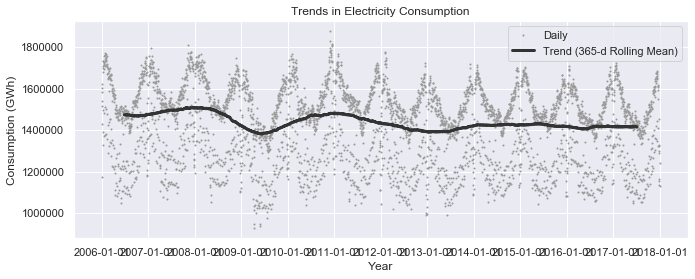

In [87]:
# trends in electricity consumption
fig, ax = plt.subplots()
ax.plot(data_f['Load'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
# ax.plot(opsd_7d['Consumption'], linewidth=2, label='7-d Rolling Mean')
ax.plot(opsd_365d['Load'], color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption');

- Not much increase in the usage

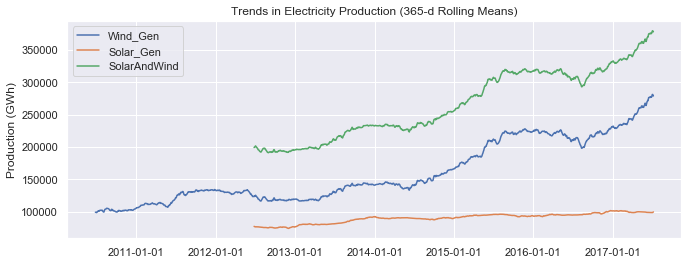

In [88]:
#trends in electricity production
fig, ax = plt.subplots()
for nm in ['Wind_Gen', 'Solar_Gen', 'SolarAndWind']:
    ax.plot(opsd_365d[nm], label=nm)
    # Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.set_ylim(0, 5)
    ax.legend()
    ax.set_ylabel('Production (GWh)')
    ax.set_title('Trends in Electricity Production (365-d Rolling Means)');

- Increase in the usage of both solar and wind

# Time series forecasting

In [89]:
#Time series prediction
db_name = "TimeSeries.db"
db_conn = create_connection(db_name)
query = "SELECT substr(utc_timestamp, 1, 10) as Time, Load, Solar_Gen, Wind_Gen, SolarAndWind FROM FinalTable"
result = execute_query(db_conn, query)
main_data_frame = pd.DataFrame(result, columns=["Time", "Load", "Solar", "Wind", "SolarAndWind"])
main_data_frame['Time'] = pd.DatetimeIndex(main_data_frame['Time'])

In [90]:
def time_series_forecaster(training_frame,feature_type):
    try :
        if feature_type == 'Load':
            comp_frame = training_frame[['Time','Load']].copy()
            comp_frame = comp_frame.rename(columns={'Time': 'ds','Load': 'y'}) 
            title = 'Time Series Forecast of Electricity consumption Using Prophet'
        elif feature_type == 'Solar':
            comp_frame = training_frame[['Time','Solar']].copy()
            comp_frame = comp_frame.rename(columns={'Time': 'ds','Solar': 'y'})
            title = 'Time Series Forecast of Solar Power Generation Using Prophet'
        elif feature_type == 'Wind':
            comp_frame = training_frame[['Time','Wind']].copy()
            comp_frame = comp_frame.rename(columns={'Time': 'ds','Wind': 'y'})
            title = 'Time Series Forecast of Wind Power Generation Using Prophet'
        pred_train_frame = comp_frame[1:4018]
        #pred_train_frame = pred_train_frame.rename(columns={'Time': 'ds','Load': 'y'})
        ts_model = Prophet(interval_width=0.95)
        ts_model.fit(pred_train_frame)
        future_dates = ts_model.make_future_dataframe(periods=365)
        forecast = ts_model.predict(future_dates)
        req_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        req_forecast = req_forecast.set_index('ds')
        req_forecast = req_forecast.loc['2017']
        #comp_frame = comp_frame.rename(columns={'Time': 'ds','Load': 'y'})
        comp_frame = comp_frame.set_index('ds')
        comp_frame = comp_frame.loc['2017'].copy()
        fig = plt.figure()
        ax = req_forecast['yhat'].plot(figsize=(20, 8),label='Forecast value')
        ax = comp_frame['y'].plot(figsize=(20, 8),label='Actual value')
        ax.legend()
        plt.title(title)
        plt.show()
        #fig = ts_model.plot(forecast,uncertainty=True)
        #fig.suptitle('Forecast model returned by prophet')
        ts_model.plot_components(forecast)
        fig = ts_model.plot(forecast,uncertainty=True)
        fig.suptitle('Trend plots by Prophet')
    except Error as e:        
        print(e)

# Observations on Forecast values and model
- Training data was provided from 2006 to 2016 time range. And predictions are calcualted for year 2017
- Forecasted values were plotted against original data of 2017 and the values are pretty closely aligned to the original data.
- Blue line corresponds to forecast values and orange are the original data points
- The further plots are generated from the model using the built in functions of prophet
- They capture the yearly,weekly,monthly trends in the data
- And the last plot corresponds to the entire time range trained and predicted. The black dots correspond to the original data points

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


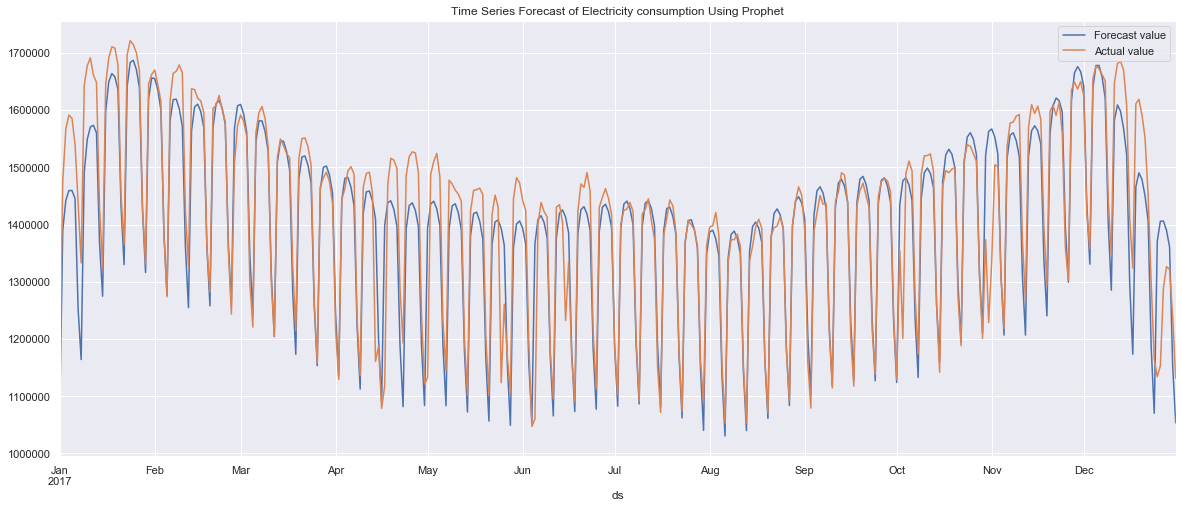

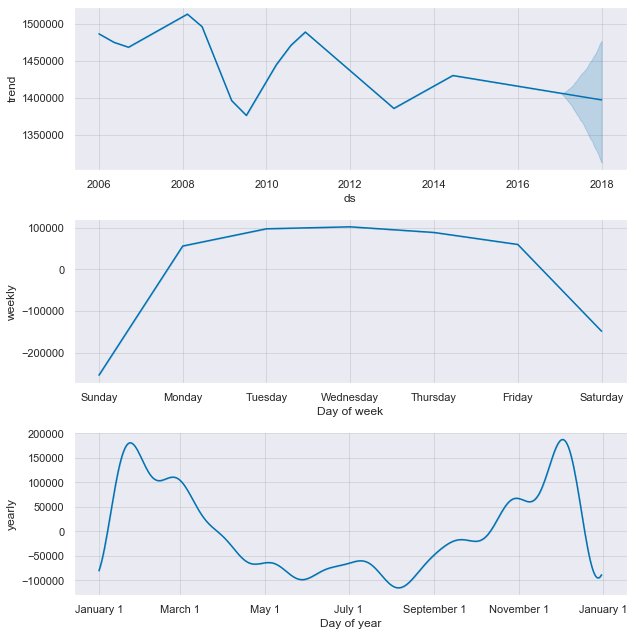

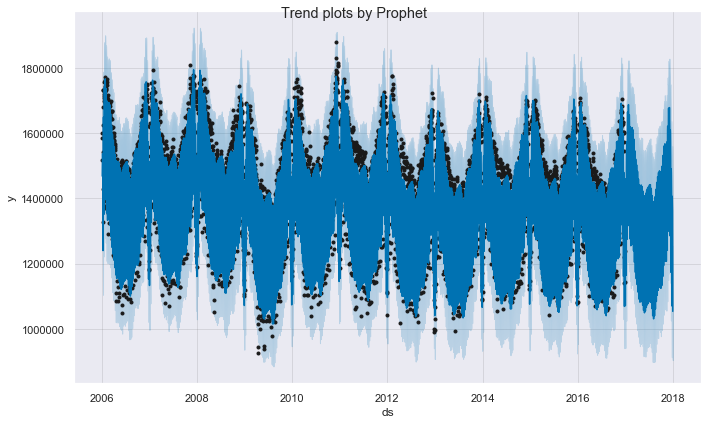

In [91]:
time_series_forecaster(main_data_frame,'Load')

## Observations on solar data
- The original data for the prediction year have many variations and pretty non-linear. However the model was able to capture the overall trend for the entire year .
- And from the trend plots we can observe the generation is higher in the months of summer as compared to the other months

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


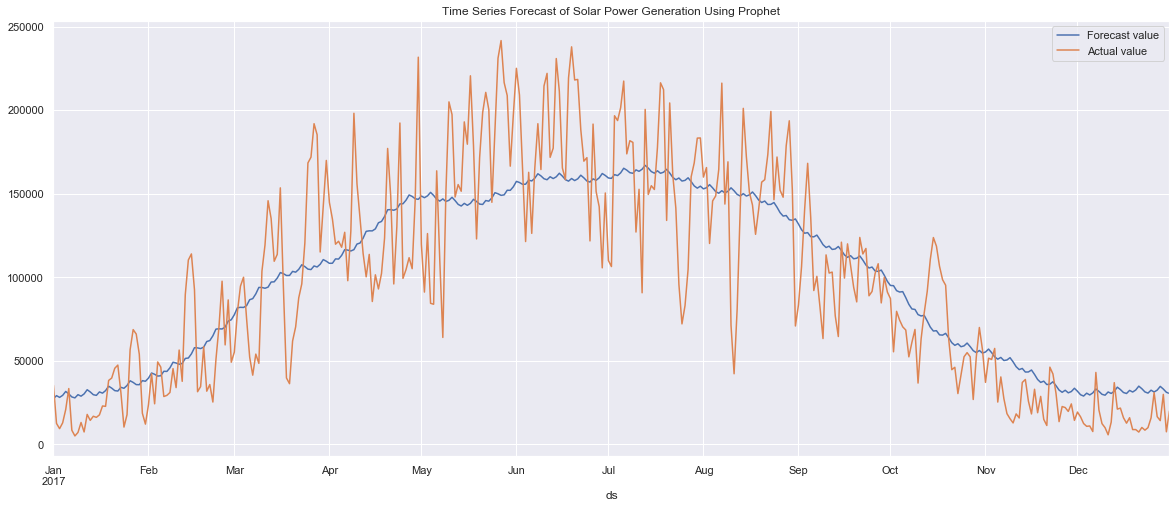

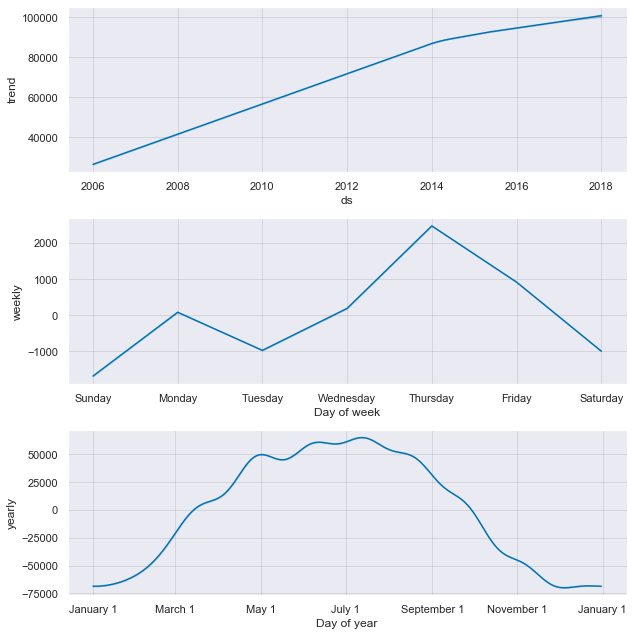

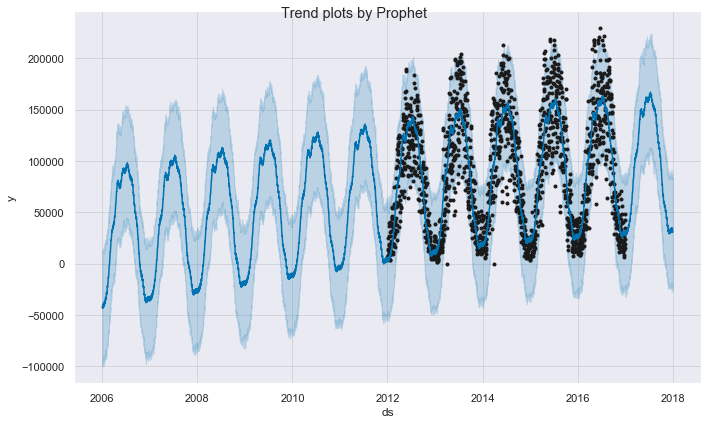

In [92]:
time_series_forecaster(main_data_frame,'Solar')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


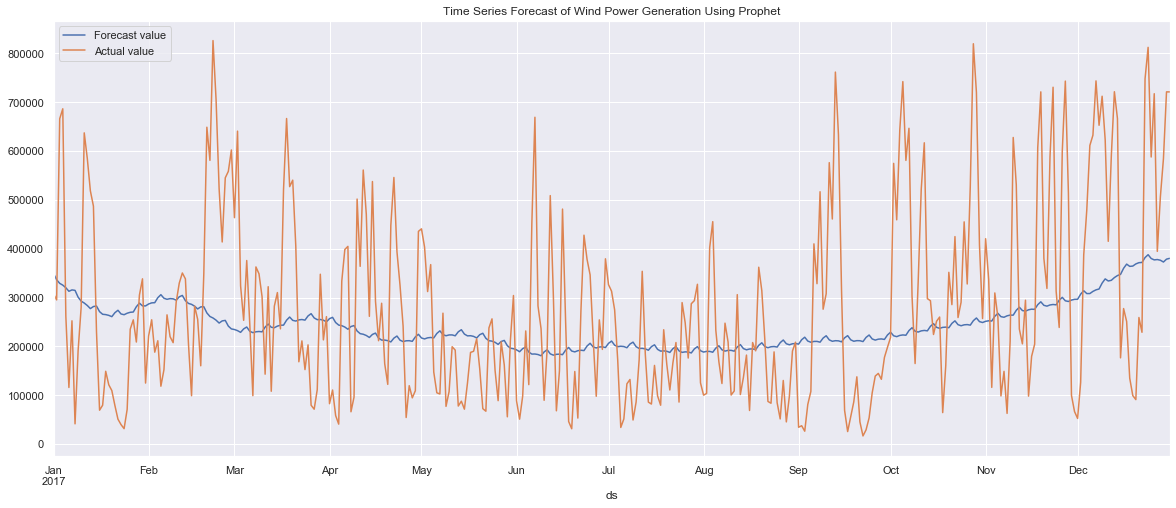

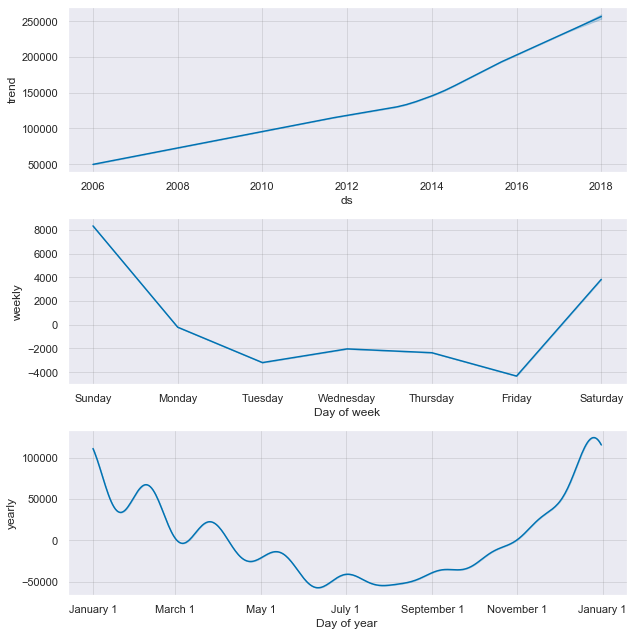

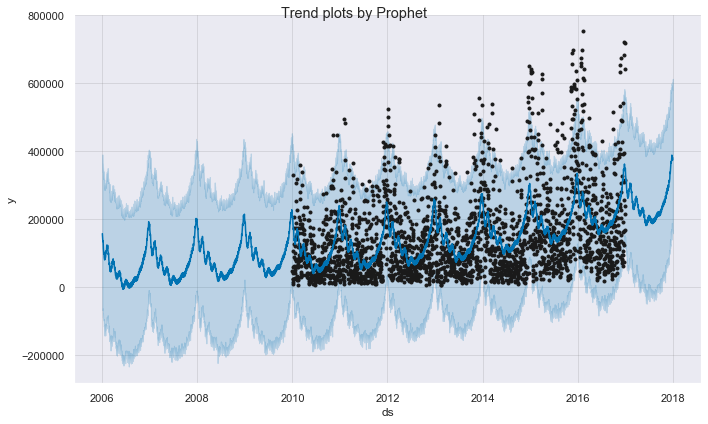

In [93]:
time_series_forecaster(main_data_frame,'Wind')